<a href="https://colab.research.google.com/github/MonkeyWrenchGang/2024_BAN7040/blob/main/17July20204_GBM_and_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# -- pandas and numpy --
import numpy as np
import pandas as pd

# -- plotting --
import matplotlib.pyplot as plt
import seaborn as sns

# -- sklearn stuff --

# -- sklearn modules
from sklearn.model_selection import train_test_split   #- partition train/test split
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier
from sklearn.ensemble import GradientBoostingClassifier #- gradient boosting classifier
from sklearn.tree import DecisionTreeClassifier         #- decision tree classifier

# -- we need these to make our pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV # NOTE...
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# -- we need these to evaluate our models
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# -- need this to render charts in notebook --
%matplotlib inline

## Stage


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/2024_BAN7040/main/Churn_training.csv")

df = df.sample(frac=0.1).reset_index(drop=True)
df.head(5)

,monthly_minutes,customer_service_calls,streaming_minutes,total_billed,prev_balance,late_payments,ip_address_asn,phone_area_code,customer_reg_date,email_domain,...,currency_code,maling_code,paperless_billing,payment_method,customer_id,billing_address,gender,network_speed,senior_citizen,churn
0,16009.0,1.0,19932.0,284.0,63.0,3.0,49611.0,243.0,2020-01-06,gmail.com,...,cad,B,No,Mailed Check,1-333-22929-1.16968,2623 Kristin Mills Apt. 172,Male,4Glte,0.0,0
1,9951.0,1.0,20733.0,256.0,52.0,5.0,18789.0,255.0,2020-03-22,gmail.com,...,cad,W,No,Mailed Check,0-934798-38-9.70897,015 Charlene Mount,Female,5G,0.0,0
2,12430.0,1.0,16689.0,266.0,59.0,3.0,51077.0,256.0,2020-08-22,gmail.com,...,cad,A,No,Mailed Check,1-960411-28-4.92974,26336 Robertson Village Apt. 799,Male,4Glte,1.0,0
3,15808.0,3.0,14130.0,220.0,52.0,5.0,53125.0,254.0,2020-06-26,gmail.com,...,cad,G,Yes,Mailed Check,0-05-557151-4.59115,008 Gaines Glens Apt. 652,Female,5G,1.0,0
4,22272.0,2.0,19261.0,196.0,40.0,6.0,14000.0,247.0,2020-05-20,gmail.com,...,cad,B,Yes,Mailed Check,0-671-46682-8.28477,072 Samantha Mews,Male,4Glte,0.0,0


In [3]:
# 1. Split features into categorical and numerical features
target = 'churn'

numeric_features = ['number_phones',
                    "late_payments",
                    "customer_service_calls",
                    "total_billed"]

categorical_features = ["phone_model"]

feature_names = numeric_features + categorical_features

# train test split

In [4]:
# Separate the features and the target variable
X = df.drop('churn', axis=1)
y = df['churn']  # Target variable column name

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)

print(f"X_train % : {X_train.shape[0]/df.shape[0]:.2%}")
print(f"X_test  % : {X_test.shape[0]/df.shape[0]:.2%}")

X_train % : 70.00%
X_test  % : 30.00%


# Create Pipeline Preprocessor
---

simple imputer default value


In [5]:
# Create the preprocessing pipelines
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='UNK')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])




# Baseline Fit Random Forest

In [6]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100,
                                                                    max_depth=10,
                                                                    n_jobs=-1,
                                                                    random_state=42))])
# Train the pipeline
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['number_phones',
                                                   'late_payments',
                                                   'customer_service_calls',
                                                   'total_billed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNK',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['phone_model'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_jobs=-1,
                                        random_state=42))])

## Baseline GBMClassifier

In [7]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
gbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(
                                                                        learning_rate=0.1, n_estimators=100,
                                                                    ))])
# Train the pipeline
gbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['number_phones',
                                                   'late_payments',
                                                   'customer_service_calls',
                                                   'total_billed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNK',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['phone_model'])])),
                ('classifier', GradientBoostingClassifier())])

In [8]:
# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Print the metrics
print("Random Forest Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")


Random Forest Model Evaluation:
  Accuracy: 0.9432
  AUC: 0.8353
  Precision: 0.7778
  Recall: 0.1235


In [9]:
# Predictions
y_pred_gbm= gbm_pipeline.predict(X_test)
y_pred_proba_gbm = gbm_pipeline.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_gbm)
auc_rf = roc_auc_score(y_test, y_pred_proba_gbm)
precision_rf = precision_score(y_test, y_pred_gbm)
recall_rf = recall_score(y_test, y_pred_gbm)

# Print the metrics
print("GBM Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")

GBM Model Evaluation:
  Accuracy: 0.9417
  AUC: 0.8280
  Precision: 0.6279
  Recall: 0.1588


In [10]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [100,200],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(gbm_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters:
  classifier__learning_rate: 0.1
  classifier__n_estimators: 200


# Results of CV

In [11]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.230171,0.062498,0.047928,0.004919,0.05,100,"{'classifier__learning_rate': 0.05, 'classifie...",0.801296,0.859104,0.846584,0.835661,0.024832,5
1,1.995958,0.260951,0.045015,0.011146,0.05,200,"{'classifier__learning_rate': 0.05, 'classifie...",0.819578,0.863430,0.858100,0.847036,0.019537,2
2,0.886903,0.192888,0.031344,0.010424,0.1,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.822380,0.859296,0.858796,0.846824,0.017286,3
3,1.634600,0.093039,0.035349,0.003546,0.1,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.826637,0.860196,0.855221,0.847351,0.014788,1
4,0.940318,0.032190,0.024889,0.000831,0.2,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.818645,0.859122,0.846723,0.841497,0.016933,4
5,1.547312,0.249202,0.031233,0.001951,0.2,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.803061,0.837421,0.836847,0.825776,0.016064,6


# Graph

<Axes: xlabel='param_classifier__n_estimators', ylabel='mean_test_score'>

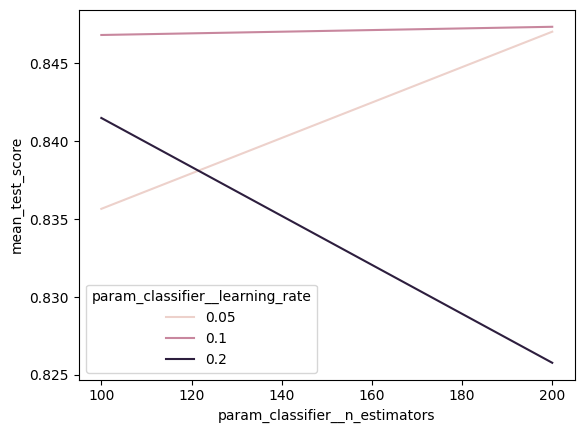

In [12]:
sns.lineplot(data=cv_results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__learning_rate')

In [13]:
best_params

{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}

# Refit with Best Parameters

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
gbm_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(n_estimators=200,
                                                                    learning_rate=0.05,
                                                                    ))])
# Train the pipeline
gbm_pipeline_hpo.fit(X_train, y_train)

In [ ]:
# compare rf_pipeline to rf_pipeline_hpo performance
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

y_pred_gbm  = gbm_pipeline.predict(X_test)
y_pred_proba_gbm = gbm_pipeline.predict_proba(X_test)[:, 1]

y_pred_gbm_hpo  = gbm_pipeline_hpo.predict(X_test)
y_pred_proba_gbm_hpo = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Random Forest Model Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_rf):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf):.3f}")

print("\n -------- ")
print("GBM Baseline:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm):.3f}")

print("\n -------- ")
print("GBM Optimized:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm_hpo):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm_hpo):.3f}")